In [1]:
import math
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [2]:
stock_data = yf.download('TCS',start='2012-01-01',end='2022-12-31')
stock_data = yf.download('LT.NS',start='2012-01-01',end='2022-12-31')
stock_data = yf.download('HCL',start='2012-01-01',end='2022-12-31')
stock_data = yf.download('WIPRO.NS',start='2012-01-01',end='2022-12-31')
stock_data = yf.download('TECHM.NS',start='2012-01-01',end='2022-12-31')
stock_data = yf.download('REDINGTON.NS',start='2012-01-01',end='2022-12-31')
stock_data = yf.download('ITC',start='2012-01-01',end='2022-12-31')
stock_data = yf.download('CYIENT.NS',start='2012-01-01',end='2022-12-31')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Text(0, 0.5, 'Prices ($)')

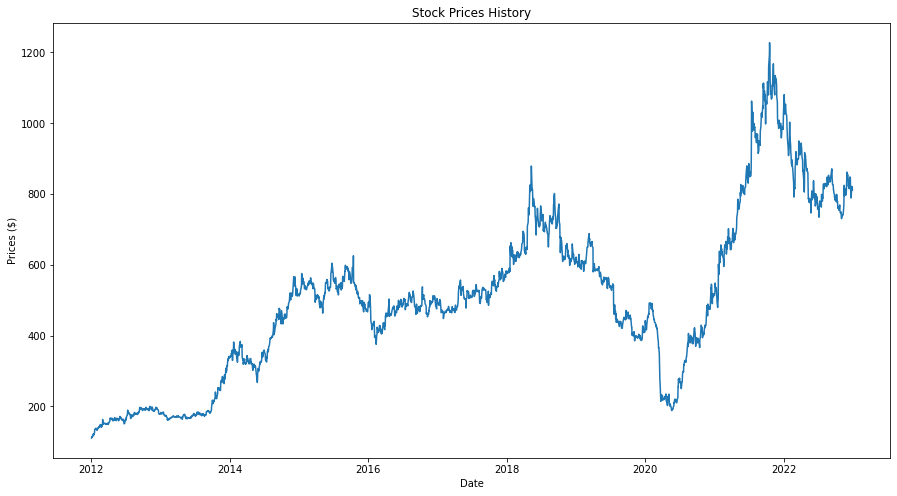

In [8]:
plt.figure(figsize=(15, 8))
plt.title('Stock Prices History')
plt.plot(stock_data['Close'])
plt.xlabel('Date')
plt.ylabel('Prices ($)')

In [3]:
close_prices = stock_data['Close']
values = close_prices.values
training_data_len = math.ceil(len(values)* 0.8)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))
train_data = scaled_data[0: training_data_len, :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [4]:
test_data = scaled_data[training_data_len-60: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [5]:
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 25)                2525      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________


In [6]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 30, epochs=25)

Epoch 1/25
71/71 [==============================] - 7s 55ms/step - loss: 0.0049
Epoch 2/25
71/71 [==============================] - 4s 52ms/step - loss: 3.7776e-04
Epoch 3/25
71/71 [==============================] - 4s 50ms/step - loss: 3.4696e-04
Epoch 4/25
71/71 [==============================] - 4s 51ms/step - loss: 3.4190e-04
Epoch 5/25
71/71 [==============================] - 4s 54ms/step - loss: 3.0329e-04
Epoch 6/25
71/71 [==============================] - 4s 52ms/step - loss: 2.8829e-04
Epoch 7/25
71/71 [==============================] - 4s 55ms/step - loss: 3.0312e-04
Epoch 8/25
71/71 [==============================] - 4s 57ms/step - loss: 2.6396e-04
Epoch 9/25
71/71 [==============================] - 4s 60ms/step - loss: 2.7168e-04
Epoch 10/25
71/71 [==============================] - 4s 58ms/step - loss: 2.3503e-04
Epoch 11/25
71/71 [==============================] - 4s 58ms/step - loss: 2.2237e-04
Epoch 12/25
71/71 [==============================] - 4s 59ms/step - loss: 2.19

In [7]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

17/17 [==============================] - 1s 19ms/step


7.7381255653071666

C:\Users\DELL\AppData\Local\Temp\ipykernel_6016\154904543.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


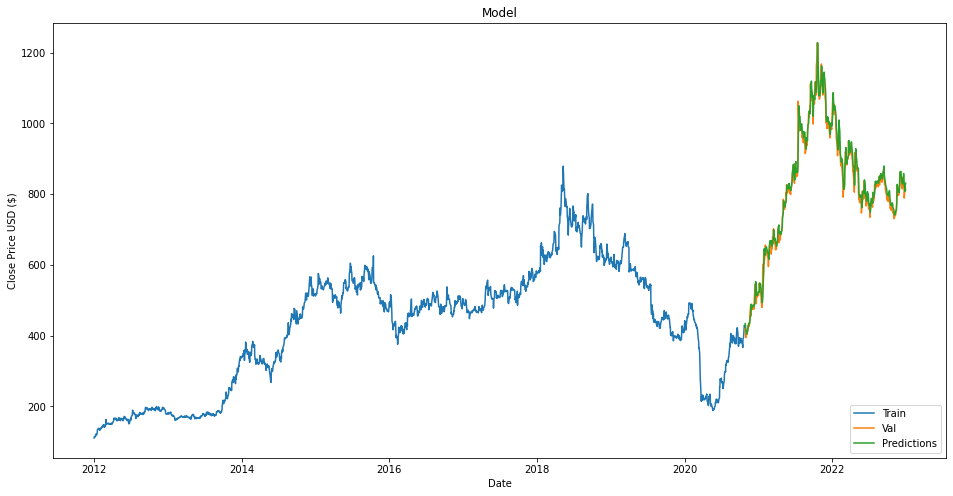

In [9]:
data = stock_data.filter(['Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [18]:
filename = 'finalized_model.sav'
joblib.dump(model, filename)

loaded_model = joblib.load(filename)
result = loaded_model.score(x_test, y_test)
print(result)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\lstm
......vars
...layers\lstm\cell
......vars
.........0
.........1
.........2
...layers\lstm_1
......vars
...layers\lstm_1\cell
......vars
.........0
.........1
.........2
...metrics\mean
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........17
.........18
.........19
.........2
.........20
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-01-28 11:53:02         3061
metadata.json                                  2023-01-28 11:53:02           64
variables.h5                                   2023-01-28 1

AttributeError: 'Sequential' object has no attribute 'score'